# Introduction

When I began as an interventionist in a busy secondary school maths department, a particular statement stuck with me. "It's really about each of their skills" a teacher remarked as we discussed a strategy for me to best support his class of Year 11s. Over time, I came to appreciate this insight and embedded it into my approach to effectively support students who had managed to slip through the cracks.

From this perspective, skills are at the heart of one's education in mathematics. Think about where we start: learning foundational skills such as addition and division. Once these are mastered, we utilise them in learning new skills such as adding fractions, and this process continues. Think about where we end: anxiously answering questions in the final exam. These questions test our mathematics skills and often a few at a time. Skills constitute our mathematics ability.

Conversely, skills must also be at the centre of underachievement. Take a student who is struggling to get their head around a concept or a question. It could be a single skill which creates the gap between knowing and not knowing. Every student will have contended with these gaps; and educators work tirelessly to fill them.


Simplifying and facilitating this challenge, Ragnar illuminates these gaps *by*:
* Utilising potentially vast diagnostic mathematics test score data
* Optimising a statistical model using an Expectation Maximisation (EM) algorithm

*In order to:*
* Predict the most likely levels of skills for each student
* Present comprehensible overviews to teachers/departments regarding these skills
* Provide constructive skills-based feedback to students

***
*Ragnar is a name from Old Norse origin meaning "warrior" - how one could picture a student in their own right - and "judgement," which is the point of the model - to effectively judge test scores. In this case, Ragnar primarily comes from the acronym "RAG," frequently used in education to describe a process of providing feedback to students.*

Note to the reader: To streamline the notebook I cut out the bulk of the derivations and code for this EM algorithm however, if you're like me and *love* getting down to the nitty gritty, please refer to the appendix and the source code (kaggle input) respectively. One last thing - this is my first Kaggle submission so I appreciate all feedback!

# Data and Preprocessing

At least in the British secondary education system, Question-Level Analysis (QLA) is an established way of collecting student test data. A QLA is a spreadsheet where, once they finish marking a test, a teacher inputs the number of marks achieved for each question for each student. It is common practice for QLAs to include simple summary measures for questions, such as an average mark, and students, like total marks.

In this study, a simple QLA was used to collect the score data for a test I gave to a class of year 10 students (yes, they suffered for you). Below I present this QLA (note that the scores have been anonymised). The columns contain scores for each question (broken down into their parts where applicable) and each row contains the scores for each student (Alpha, Bravo, ...). I also include the final row which denotes the total marks avaiable for each question. This is as standard as a QLA gets.

In [1]:
import pandas as pd
import openpyxl

qla_df = pd.read_excel('/kaggle/input/ragnar-data/QLA.xlsx')
pd.concat([qla_df.head(5), qla_df.tail(1)])

,Name,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q9,Q10,Q11,Q12,Q13a,Q13b
0,Alpha,1,1,1,2,2,2,2,2,1,2,1,0,0
1,Bravo,1,1,0,2,0,0,0,0,1,0,0,0,0
2,Charlie,0,0,0,1,1,0,1,0,0,1,0,0,0
3,Delta,1,1,0,2,1,2,2,1,2,1,1,0,0
4,Echo,1,1,1,2,2,0,2,1,1,1,0,0,0
24,Total Marks,1,1,1,2,2,2,2,2,2,2,3,3,2


Skills are latent (not directly observable) variables. However, from how a student performs in a test, we can get a picture of what these skills might look like. For instance, if a student is systematically failing questions using Pythagoras' Theorem, we can infer they are weak in this skill. In essence, Ragnar treats each mark as a signal and deals with each of these signals in an optimal way to return a 'best guess' on student skills. In the remainder of this section, the QLA is transformed so that this process can take place.

### Marks as Signals

Given marks provide varying information about student skills, we would like our question-level score data to tell us precisely which marks were correct. Here this wasn't an issue since the test I administered was diagnostic. This is meant in the sense that, for example, if a student got two out of three marks, we can be sure they got the first two parts correct and the final part incorrect (In other contexts, it isn't this easy where tests are generally used as summative measures of performance but see the discussion section for a full discussion).

Firstly, some key data is extracted from the QLA:

In [2]:
questions = qla_df.columns.tolist()[1:]
students = qla_df["Name"].tolist()[:-1]
total_marks = qla_df.loc[qla_df["Name"]=="Total Marks"].values[0][1:]

#A dictionary where keys are questions and values are a list of marks contained within that question
mark_dict = {} 
current_mark = 1
for i in range(len(questions)):
        mark_dict[questions[i]] = [m for m in range(current_mark, current_mark + total_marks[i])]
        current_mark += total_marks[i]

#A list of every mark
marks = list(range(1, current_mark)) 

print("List of Questions: ", questions)
print("List of Students: ", students)
print("Dictionary of Marks: ", mark_dict)
print("Total Marks Available: ", len(marks))

List of Questions:  ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13a', 'Q13b']
List of Students:  ['Alpha', 'Bravo', 'Charlie', 'Delta', 'Echo', 'Foxtrot', 'Golf', 'Hotel', 'India', 'Juliet', 'Kilo', 'Lima', 'Mike', 'November', 'Oscar', 'Papa', 'Quebec', 'Romeo', 'Sierra', 'Tango', 'Uniform', 'Victor', 'Whiskey', 'X-ray']
Dictionary of Marks:  {'Q1': [1], 'Q2': [2], 'Q3': [3], 'Q4': [4, 5], 'Q5': [6, 7], 'Q6': [8, 9], 'Q7': [10, 11], 'Q9': [12, 13], 'Q10': [14, 15], 'Q11': [16, 17], 'Q12': [18, 19, 20], 'Q13a': [21, 22, 23], 'Q13b': [24, 25]}
Total Marks Available:  25


To generate a binary array indicating correct and incorrect marks for a given student the following function is used.

In [3]:
def get_scores(student):
    s_scores = qla_df.loc[qla_df["Name"]==student].values[0].tolist()[1:]
    s_marks = []
    for index, q in enumerate(questions):
        s_marks_q = [0 for i in range(len(mark_dict[q]))] #initialise an array of zeros for marks in question q
        for i in range(s_scores[index]):
            s_marks_q[i] = 1 #Change 0s to 1s. For example, the first and second marks of a question are 1 if they got 2/3. 
        s_marks += s_marks_q
    
    return s_marks

print(get_scores('Alpha'))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


Combining what we have so far, we can generate an expanded QLA providing score information at the mark level.

In [4]:
score_df = pd.DataFrame({'Name': marks}) #DataFrame first column
for student in students:
    score_df_s = pd.DataFrame({student: get_scores(student)})
    score_df = pd.concat([score_df, score_df_s], axis=1) #Append columns to DataFrame
score_df.set_index("Name").transpose().tail()

Name,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
Tango,1,0,1,1,1,1,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
Uniform,1,1,1,1,1,1,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
Victor,1,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Whiskey,1,0,1,1,0,1,1,1,1,0,...,1,0,0,0,0,0,0,0,0,0
X-ray,1,0,1,1,1,0,0,1,1,1,...,1,1,1,1,1,0,0,0,0,0


This looks identical to our original QLA except, now, the columns relate to each of the 25 marks available. The data is binary since an individual can either get the mark (1) or not (0).

### Selecting Signals

Take, for example, a student who gets one out of three marks in a question. They completed the first step correctly. When they got to the second step, they were incorrect and lost this mark. Given they went wrong on this second step, it would have been impossible to get the third step right. Therefore, this third mark provides no more information about a student's skills than the second.

Signals like these are removed from our analysis. The following function is used to decide whether we the signal is used (1) or not (0).

In [5]:
def get_sigs(student):
    scores = get_scores(student)
    signals = [0 for _ in range(len(scores))]
    for q, q_marks in mark_dict.items():
        for index, mark in enumerate(q_marks):
            #If it is the first part of any question the signal is used
            if index == 0: 
                signals[marks.index(mark)] = 1
            #For any other part of a question, signal is used if the previous mark was correct
            else: 
                if scores[marks.index(mark)-1] == 1:
                    signals[marks.index(mark)] = 1
            #Otherwise, the signal is not used
    return signals

print(get_sigs("Alpha"))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0]


Now that we have our signals, how do we think about the information they provide? In the next section, I establish a simple framework for thinking about skills and their usage in questions.

# Model Building

### Baseline Model

To eventually infer a student's skill levels from these marks, we must firstly define what a skill is. A skill in this context is a resource a student draws upon to take the next step in answering a question correctly. For example, in order to calculate the longest side of a right-angled triangle given the two shorter sides, an individual must firstly understand Pythagoras' Theorem, be able to substitute into the formula, and then algebraically solve for the answer. Each step requires its own skill and each skill may contain their own skills depending on our level of detail. Given a level of detail, I define skill $k$ as a variable between zero and one:

$$
Y^k \in[0,1]
$$

A student $i$ has various skills (for $k=1,...K$) at varying levels. This skill set is defined as:

$$
Y_i = (Yi^1,...,Y_i^K)
$$

Ragnar considers an underlying model for the achievement of each mark. For any mark $j$ (with score $X_j$), each skill must be above a certain threshold for an individual to be *competent* which, in theory, means they score correctly ($X_j=1$ rather than $0$). Our theoretical model for $X_j$ is as follows:

$$
\begin{align}
X_{ij} & = \prod_k1(Y_i^k\geq T^k_j)\\
\end{align}
$$

Where $1(\cdot)$ is a standard indicator function and $T^k_j$ are our thresholds for each skill. The function reflects our measure of competency defined earlier: If all skills are above the threshold then each indicator function is equal to one and so their product will equal one. This implies the student is competent so they achieve the mark. Note that functional form can also include skills not used in mark $j$ by simply setting $T^k_j=0$.

In a perfect world, our model is absolute. Our thresholds are set perfectly and getting a mark right or wrong is completly determined by this underlying model. If an individual gets a mark correct, we can be certain their skills lie above the thresholds and take this as a given.

### A Less Perfect World

In the real world, the underlying model and actual outcomes will not align perfectly. In fact, the model might be a really poor way of describing reality. This is for two broad reasons.

* **Alternative Explanations:** The model is not absolute. There are a plethora of other reasons as to why a student may or may not pick up a mark. An obvious one is that people make mistakes. Secondly, skills might operate differently to the model assumes. For instance, despite a skill being below the threshold, a different stronger skill may make up for this and allow the student to get the mark.

* **Inaccurate Model Building:** Threshold parameters are preset by a human model builder in this setup. Whilst it's expected the model builder knows something about gauging difficulties of skills used in a mark, they are will have their own biases and inaccuracies. As such, our measure of competency for each mark won't be perfect.

***

##### Aside: A Method to Setting Skills

Before discussing the mathematical implications, I provide a method for the model builder to set the skills and thresholds for each mark. 

Each skill corresponds an integer key and each threshold lies between 0 and 1, reflecting the difficulty of using the skill in the context of the mark. The model builder can use the following data frame for this.

In [6]:
max_skills = 5 #Maximum number of skills used in each question
skill_data = []
cols = ["Mark", "Question", "Question Mark", "Skills"] + ["T" + str(i+1) for i in range(max_skills)]

for q, q_marks in mark_dict.items():
    for index, m in enumerate(q_marks):
        skill_data.append([m, q, index+1, ""]+[""for i in range (max_skills)]) #generate rows for each mark
        
skill_data = pd.DataFrame(skill_data, columns = cols).set_index("Mark")
skill_data.head()

,Question,Question Mark,Skills,T1,T2,T3,T4,T5
Mark,,,,,,,,
1,Q1,1,,,,,,
2,Q2,1,,,,,,
3,Q3,1,,,,,,
4,Q4,1,,,,,,
5,Q4,2,,,,,,


Here, each mark has its own row. In the skills column, the model builder inputs a list of the integer skills relevant to the mark. The following columns require a threshold for each skill in the order of that in the skills column. 

Below I present a completed version for the test used in this notebook. The skills and their integer keys are:
1. Simplifying Surds
2. Multiplying and Dividing Surds
3. Adding and Subtracting Surds
4. Expanding Brackets
5. Triangle Geometry

In [7]:
skill_data = pd.read_excel('/kaggle/input/ragnar-data/Skill Data.xlsx')
skill_data.fillna('')

,Mark,Question,Question Mark,Skills,T1,T2,T3,T4,T5
0,1,Q1,1,1,0.124,,,,
1,2,Q2,1,1,0.146,,,,
2,3,Q3,1,1,0.202,,,,
3,4,Q4,1,2,0.125,,,,
4,5,Q4,2,1,0.353,,,,
5,6,Q5,1,2,0.352,,,,
6,7,Q5,2,1,0.354,,,,
7,8,Q6,1,1,0.124,,,,
8,9,Q6,2,1,0.457,,,,
9,10,Q7,1,1,0.436,,,,


***

### The Augmented Model

As we have discussed, the model is not a perfect representation of the process underlying a student's success in a mark. Therefore, an error term $u_{ij}$ that accounts for this discrepancy is introduced. $u_{ij}$ effectively dictates whether or not our measure of competency for mark $j$ is mirrored in its score $X_{ij}$. The augmented model is as follows.

$$
X_{ij} = \prod_k1(Y_i^k\geq T^k_j) + u_{ij}
$$

and the following assumptions are made:
1. The prior distribution over $Y^k\in[0,1]$ is continuous and uniform for all $k$ and individuals $i$
2. For a given mark $j$, the error terms $u_{ij}$ for each $i$ are independently and identically distributed according to parameter $\theta_j$ such that $\theta_j = P\left(u_{ij}=0\right)$

Assumption one tells us that, prior to using the signals to update our beliefs on skills, there is no "best guess" for a skill $Y_i^k$ given it has a flat probability distribution. The second assumption implies $\theta_j$ represents the quality of our measure of competency. It is the probability that our measure of competency for mark $j$ and the score $X_{ij}$ are in agreement since $\theta_j = P\left(u_{ij}=0\right) = P\left(X_{ij}=\prod_k1(Y_i^k\geq T^k_j)\right)$ *(See the appendix for a more rigorous definition)*.


# Estimation Strategy

We now have a distribution on $u_{ij}$ parametrised by $\theta_j$, yielding a probablistic interpretation of each signal. Combined with the assumed prior distribution on each $Y^k$, we can update our beliefs on student skills using a Bayesian framework. This section is concerned with doing so optimally using the Expectation Maximisation (EM) algorithm.

### Belief Updating

To utilise the EM algorithm, we need a framework for updating skills based on our signal given our parameters $\theta$. Firstly, consider the following:

$$P(X_{ij}=1|Y_i) = \prod_k1(Y_i^k\geq T^k_j)\times \theta_j+\left(1-\prod_k1(Y_i^k\geq T^k_j)\right)\times (1-\theta_j)$$
$$P(X_{ij}=0|Y_i) = \prod_k1(Y_i^k\geq T^k_j)\times (1-\theta_j)+\left(1-\prod_k1(Y_i^k\geq T^k_j)\right)\times \theta_j$$

As the probability of our observed variable conditional on our unobserved variable, these two equations provide us with our first step in updating. Consider the first. It states that if $Y_i$ is such that $i$ is competent for $j$ then the probability we see a correct score is $\theta_j$. On the other hand, if $i$ is not competent for $j$ then the probability becomes $1-\theta_j$. Therefore, notice this conditional probability depends on $\theta_j$ so we can write it as $P(X_{ij}=1|Y_i, \theta_j)$.

Since error terms are assumed uncorrelated within $i$, we can write the overall conditional probability of seeing all scores as:

$$
P(X_i|Y_i,\theta) = \prod_jP(X_{ij} | Y_i, \theta_j)
$$

Given an observation of a set of signals, we can update the skills using:

$$
P(Y_i|X_i, \theta_j) = \frac{\prod_jP(X_{ij}|Y_i,\theta_j)P(Y_i)}{P(X_i| \theta)}
$$

Where $P(Y_i)$ uses the prior distribution on $Y_i$ which is assumed as uniform across the domain $[0,1]$. 

The denominator of this fraction, $P(X_i|\theta)$, can be viewed as the likelihood of seeing $i$'s scores. Combined with the assumption scores are independent across $i$, our overall likelihood of the observed scores for all $i$ can be calculated as:

$$
L(\theta;X) = P(X|\theta) =\prod_i\left(\sum_{Y_i}\left[\prod_jP(X_{ij}|Y_i,\theta_j)\right]P(Y_i)\right)
$$

### Optimal Beliefs: EM Algorithm

Given the likelihood is a function of $\theta$, we can decide a best way to set this parameter. An obvious way is to choose the Maximum a Posteriori (MAP) estimates. In other words, we want the $\theta$ that produces the observed scores with the greatest likelihood. Our problem is as follows.

$$
\max_{\theta} \prod_i\left(\sum_{Y_i}\left[\prod_jP(X_{ij}|Y_i,\theta_j)\right]P(Y_i)\right)
$$

A common measure to simplify such a problem is to take logs:

$$
\max_{\theta}\sum_ilog\sum_{Y_i}\left[\prod_jP(X_{ij}|Y_i,\theta_j)\right]P(Y_i)
$$

Ideally, we would take first (and maybe second) derivatives to find a $\theta$ that maximises this function. However, this is made tricky by the $log\sum_{Y_i}()$ above. A work around for this is the Expectation Maximisation (EM) algorithm which is commonly used for latent variable problems such as this one.

The EM algorithm accepts that this log likelihood function is difficult to optimise directly. Instead, it finds a lower bound for this function that is easier to optimise. This lower bound is pinned down by an initial parameter value $\theta_t$ and it is then optimised with respect to $\theta$ to find a new value $\theta_{t+1}$. The process until we approach an optimum which is visually demonstrated below.

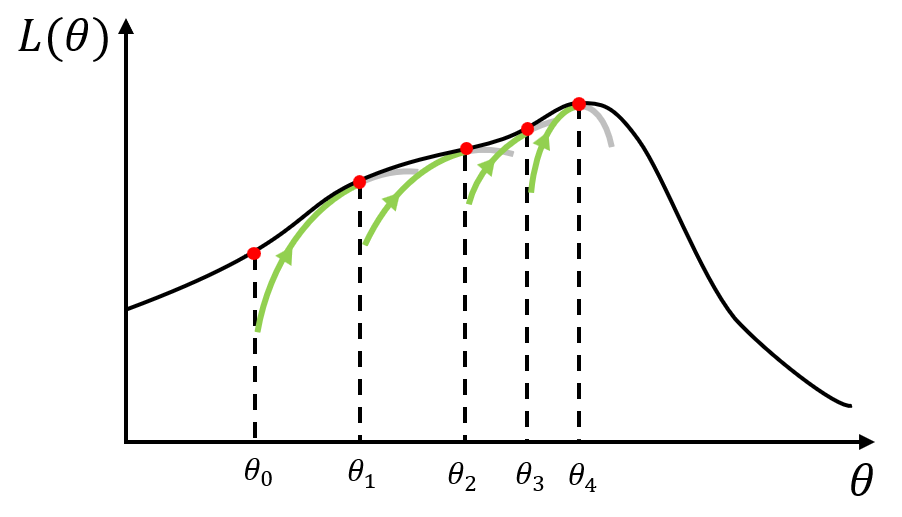

In [8]:
from IPython.display import Image
from ipywidgets import widgets, Layout
Image("/kaggle/input/ragnar-data/EM Diagram.png", width=600)

Each $\theta_t$ pins down the lower bound of the log likelihood (green curve) and we optimise this yielding $\theta_{t+1}$. As we update, the log likelihood (black curve) and the lower bound converge and we are left with a (local) optimum.

Thinking about $\sum_{Y_i}()P(Y_i)$ and $E_{Y_i}()$, we can rewrite log likelihood and its lower bound as:

$$
\begin{align}
l(\theta; X) &= \sum_ilogE_{Y_i}\left[\prod_jP(X_{ij}|Y_i,\theta_j)\right]\\ 
&\geq\sum_iE_{Y_i}log\left[\prod_jP(X_{ij}|Y_i,\theta_j)\right]
\end{align}
$$

The second line is given by Jensen's inequality since the function $ln(\cdot)$ is concave. This is the lower bound of our log likelihood function and setting its first order derivative to zero yields the following rule for updating $\theta$:

$$
\boxed{
\theta_{j, t+1}=\frac{1}{N}\sum_{i_{j1}}\prod_kP(Y_i^k\geq T^k_j|x_i,\theta_t)+\frac{1}{N}\sum_{i_{j0}}\left[1-\prod_kP(Y_i^k\geq T^k_j|x_i,\theta_t)\right]
}
$$

Where $i_{j1}$ and $i_{j0}$ are the set of individuals who got $j$ correct and incorrect respectively. The probability distribution on $Y$ used to calculate $P(Y_i^k>T^k_j|x_i,\theta_t)$ is the posterior distribution after having applied a bayesian update, dependant on $x_i$ and, as discussed, $\theta_t$. For a full derivation, see the appendix.

# Model Optimisation and Outputs
    
In this section, the model is optimised using the above relation and we obtain an optimum quickly. The posterior distribution for each skill is then produced. The general principle for this algorithm is detailed below.
    
1. Initialise starting parameter set $\theta_0$.
2. Each skill has a set of thresholds attatched to it. Divide each skill's domain into bins defined by these thresholds (e.g., [0,0.18],[0.18,0.43],[0.43,0.78], [0.78,1]). Define a skill combination as $Y=\{Y^1,Y^2,Y^3,Y^4,Y^5\}$ where $Y^k$ is a given bin for skill $k$. Find every possible combination of these bins and assign a prior probability to each of these skill combinations.
3. E-Step: With our current paramater estimate, calculate the posterior probilities over the skills for each individual $P(Y_i|X_i, \theta_t)$.
4. M-Step: Use equation defined in the last section to choose $\theta_{t+1}$.
5. If we have not met stopping condition return to step 4, setting $\theta_{t}=\theta_{t+1}$.

*Please feel free to look at the [source code](https://www.kaggle.com/code/zakariyankhan/ragnar-utils)*

##### 1. Initialising Parameter Values

In [9]:
import numpy as np
import ragnar_utils

def get_theta0(value):
    return np.array([value for _ in range(len(marks))])

theta0 = get_theta0(0.75)
print(theta0)

[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75
 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]


##### 2. Prior Probabilities for every Skill Combination

Firstly, we extract some neccessary information from the skill dataset. We return *thresh_array* which is a 2d array of the thresholds used in each mark $j$ but in a specified order of skills. Where the skill is not used, the threshold is replaced with zero since this is equivalent.

In [10]:
skill_dict = {}
all_skills = set()

for mark in list(skill_data['Mark'].tolist()):
    skill_dict[mark] = {}
    skills_used = [int(ele) for ele in skill_data.loc[skill_data['Mark'] == mark]['Skills'].values[0].split(',')]
    for index, skill in enumerate(skills_used):
        skill_dict[mark][skill] = float(skill_data.loc[skill_data['Mark'] == mark]['T' + str(index+1)].values[0])
        all_skills.add(skill)

all_skills = sorted(list(all_skills))

thresh_array = []
for mark, thresh_dict in skill_dict.items():
    thresh_array.append([thresh_dict[skill] if skill in thresh_dict else 0 for skill in all_skills])
thresh_array = np.array(thresh_array)

print(thresh_array)

[[0.124 0.    0.    0.    0.   ]
 [0.146 0.    0.    0.    0.   ]
 [0.202 0.    0.    0.    0.   ]
 [0.    0.125 0.    0.    0.   ]
 [0.353 0.    0.    0.    0.   ]
 [0.    0.352 0.    0.    0.   ]
 [0.354 0.    0.    0.    0.   ]
 [0.124 0.    0.    0.    0.   ]
 [0.457 0.    0.    0.    0.   ]
 [0.436 0.    0.    0.    0.   ]
 [0.    0.    0.325 0.    0.   ]
 [0.    0.    0.    0.343 0.   ]
 [0.301 0.432 0.    0.    0.   ]
 [0.    0.    0.    0.454 0.   ]
 [0.231 0.213 0.832 0.    0.   ]
 [0.    0.    0.    0.542 0.   ]
 [0.352 0.143 0.543 0.    0.   ]
 [0.    0.    0.    0.758 0.   ]
 [0.817 0.503 0.532 0.    0.   ]
 [0.    0.    0.323 0.    0.   ]
 [0.    0.    0.    0.342 0.847]
 [0.432 0.523 0.673 0.    0.   ]
 [0.    0.    0.425 0.    0.   ]
 [0.    0.415 0.913 0.    0.424]
 [0.321 0.    0.    0.    0.   ]]


Unique threshold values for a given skill can be ordered and then used to create bins for this skill, reflecting where a skill could lie. Given the bins for each skill, an array of unique skill combinations can be produced.

In [11]:
import itertools

all_unique_thresholds = []
for index, skill in enumerate(all_skills):
    unique_thresholds_skill = set(thresh_array[:, index].tolist())
    all_unique_thresholds.append(sorted(list(unique_thresholds_skill)))

combs = np.array(list(itertools.product(*all_unique_thresholds)))
combs

array([[0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.424],
       [0.   , 0.   , 0.   , 0.   , 0.847],
       ...,
       [0.817, 0.523, 0.913, 0.758, 0.   ],
       [0.817, 0.523, 0.913, 0.758, 0.424],
       [0.817, 0.523, 0.913, 0.758, 0.847]])

Note that despite the elements being single numbers, they still represent a bin within the domain of a given skill. For example, the values $0, t_1,t_2,t_3$ represent the bins $[0,t_1]$, $[t_1,t_2]$, $[t_2, t_3]$, and $[t_3, 1]$ respectively.

Below, the prior probabilities for each combination is calculated. Note that *sarrays* is a binary array indicating, for each comb and skill $k$, the bin occupied by skill $k$ in that comb. This is used in calculating the posterior distribution.

In [12]:
pcombs = np.ones(combs.shape[0])
sarrays = []
for idx, skill in enumerate(all_skills):
    thresholds_skill = sorted(list(set(thresh_array[:, idx].tolist())))
    sarray = np.zeros((combs.shape[0], len(thresholds_skill)))
    
    #Create probabilities of skill falling in a bin according to uniform distribution across [0,1]
    bin_probabilities_skill = thresholds_skill.copy()
    bin_probabilities_skill.append(1)
    bin_probabilities_skill = np.diff(bin_probabilities_skill)
    
    #Map these probabilities across combinations and multiply successively
    mapping_dict_skill = {}
    for thresh_idx, thresh in enumerate(thresholds_skill):
        mapping_dict_skill[thresh] = bin_probabilities_skill[thresh_idx]
        sarray[:, thresh_idx][combs[:, idx] == thresh] = 1
    mapping_skill = np.vectorize(mapping_dict_skill.get)
    pcombs *= mapping_skill(combs[:, idx])
    sarrays.append(sarray)

##### 3, 4, and 5. Iteratively Optimise until Condition is Met

In this subsection, we arrive at the exciting part. As I demonstated visually in an earlier figure, we iteratively implement the E-step and the M-step until we converge to an optimum of the likelihood function. Here, the stopping condition used is the tolerance regarding the step change in the log likelihood.

In [13]:
#Generate a dictionaries of both scores and signals for all students. 
scores = {}
signals = {}
for i in students:
    scores[i] = np.array(get_scores(i), dtype=int)
    signals[i] = np.array(get_sigs(i), dtype=int)

theta = theta0 #initialise parameters
logl = 0 
logl_list = []
tol = 0.01 #Tolerance
for t in range(1, 1000):
    logl_prev = logl
    posteriors, pcomp, logl = ragnar_utils.e_step(theta, pcombs, combs, thresh_array, sarrays, scores, signals, all_skills)
    theta = ragnar_utils.m_step(pcomp, signals, marks)
    logl_list.append([t, logl])
    print(f'Iteration {t}: Log Liklelihood = {logl}')
    if t > 2:
        step_change = logl - logl_prev
        if -step_change < tol:
            print("Optimisation Complete")
            print("Parameters:", theta)
            break

Iteration 1: Log Liklelihood = 259.75389164181854
Iteration 2: Log Liklelihood = 226.79634118303244
Iteration 3: Log Liklelihood = 222.06331604200048
Iteration 4: Log Liklelihood = 220.78256729191307
Iteration 5: Log Liklelihood = 220.11051071907804
Iteration 6: Log Liklelihood = 219.66225329272504
Iteration 7: Log Liklelihood = 219.33747707671728
Iteration 8: Log Liklelihood = 219.0944599633139
Iteration 9: Log Liklelihood = 218.91024833861846
Iteration 10: Log Liklelihood = 218.7695526098932
Iteration 11: Log Liklelihood = 218.66114462650728
Iteration 12: Log Liklelihood = 218.57660187122795
Iteration 13: Log Liklelihood = 218.5096672184681
Iteration 14: Log Liklelihood = 218.45576274363304
Iteration 15: Log Liklelihood = 218.41158261716672
Iteration 16: Log Liklelihood = 218.37476110233655
Iteration 17: Log Liklelihood = 218.3436123817202
Iteration 18: Log Liklelihood = 218.31693339908344
Iteration 19: Log Liklelihood = 218.29385857128378
Iteration 20: Log Liklelihood = 218.27375535

As anticipated, the EM Algorithm converged to an optimum. But this may only be local. To strengthen a claim that the optimum is global, I run the algorithm for five sets of randomised initial parameters below and present their convergence to the same optimum.

In [14]:
import random
    
traces = {}

for i in range(1,6):
    logl_i = 0
    logl_list = []
    tol = 0.5
    theta_i =  np.array([random.uniform(0, 1) for _ in range(len(marks))])
    for t in range(1, 1000):
        logl_prev = logl_i
        posteriors_i, pcomp_i, logl_i = ragnar_utils.e_step(theta_i, pcombs, combs, thresh_array, sarrays, scores, signals, all_skills)
        theta_i = ragnar_utils.m_step(pcomp_i, signals, marks)
        logl_list.append([t, logl_i])
        if t > 2:
            step_change = logl_i - logl_prev
            if -step_change < tol:
                print(f'Optimisation for Randomisation {i} Complete: Log Liklelihood = {logl_i}')
                break
    traces[i] = np.array(logl_list)


import plotly.graph_objects as go
fig = go.Figure()
for theta0, array in traces.items():
    time = array[:, 0]  # first column
    x_values = array[:, 1]  # second column
    fig.add_trace(go.Scatter(x=time, y=x_values, mode='lines', name=theta0))
    
fig.update_layout(title={'text': 'Convergence from different starting values',
                         'x': 0.5,
                         'xanchor': 'center'}, 
                  xaxis_title='Iterations', 
                  yaxis_title='-Log Likelihood',
                  paper_bgcolor='white',
                  plot_bgcolor='white',
                  legend_title_text='Randomisation #',
                  font=dict(color='black'))

fig.show()

Optimisation for Randomisation 1 Complete: Log Liklelihood = 217.07565491885643
Optimisation for Randomisation 2 Complete: Log Liklelihood = 217.57928917297608
Optimisation for Randomisation 3 Complete: Log Liklelihood = 217.71856220434526
Optimisation for Randomisation 4 Complete: Log Liklelihood = 217.8454520170577
Optimisation for Randomisation 5 Complete: Log Liklelihood = 217.71557779152846


# Visualisations

### Basic Visualisation

Since we have optimised the model, a sensible question would be: "why does this matter?" I guess the aim was to provide insight into student skills or, more technically, find the posterior distribution on each skill for each individual. Below I present the posterior distribution on the skills for individual "Alpha."

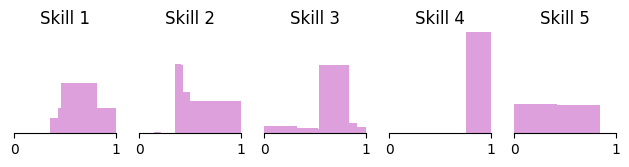

In [15]:
import matplotlib.pyplot as plt 

def display_skilldist(distributions, individual, all_skills):
    N = len(all_skills)
    fig, axs = plt.subplots(1, N)
    axs = axs.ravel()
    distributions_i = distributions[individual]
   
    max_p = []
    for index, ax in enumerate(axs): #Set initial plots
        try:
            dist = distributions_i[index]
            skillbins = dist[:, 0].tolist()
            skillbins.append(1)
            p = dist[:, 1].tolist()
            bin_widths = np.diff(skillbins)
            p_normalised = (np.array(p) / np.array(bin_widths)).tolist()
            max_p.append(np.max(p_normalised))

            ax.stairs(
                values=p_normalised,
                edges = skillbins,
                fill=True,
                color = 'plum'
            )
            axs[index].set_title("Skill " + str(all_skills[index]), wrap=True)
        except IndexError:
            axs[index].set_axis_off()
    
    ceiling = np.max(np.array(max_p))
    for index, ax in enumerate(axs): #Reformating
        try:
            axs[index].set_xlim(0, 1)
            axs[index].set_xticks([0, 1], minor=False)
            axs[index].set_ylim(0, ceiling)
            axs[index].set_yticks([])
            axs[index].yaxis.set_visible(False)
            axs[index].set_box_aspect(1)
            axs[index].spines[['top', 'right', 'left']].set_visible(False)
        except IndexError:
            continue

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    return fig
                                 
                                 
fig = display_skilldist(posteriors, 'Alpha', all_skills)

However, is this visualisation useful to a teacher or student? Perhaps an individual who has some knowledge on probability distributions might be able to infer their stronger and weaker skills. However if this is used in a school context and is aimed at supporting students, it is difficult to assume this as prior knowledge, rending this visualisation useless.

To overcome this, I transform the model outputs in more useful ways and then display them interactively. Have fun.

### Transforming Model Outputs

##### Strength

A simple metric that can be used is the expected value of each skill given its posterior distribution. Distributions with mass concentrated towards the right will have a higher expected value implying a stronger score. Below is a dataset of these values.

In [16]:
strength_list = []
for student in students:
    strength_list.append(ragnar_utils.get_expectations(posteriors[student], all_skills))
strength_data = pd.DataFrame(np.array(strength_list), columns=all_skills)
strength_data.index = students
strength_data.head()

,1,2,3,4,5
Alpha,0.670725,0.632749,0.639507,0.878992,0.421083
Bravo,0.581481,0.247559,0.464018,0.263106,0.480981
Charlie,0.062001,0.672616,0.506552,0.188966,0.485259
Delta,0.622890,0.685195,0.339827,0.878992,0.417907
Echo,0.689349,0.689083,0.268490,0.631932,0.424359


##### Limiting Skills

In grading each skill, a different way of framing the problem is to highlight skills which would yield the highest return to students. I do this by looking at the marks where a student went wrong. That is, the marks which prohibitted a student from correctly attempting later parts of questions. Looking at each of marks, I calculate for each skill the probability that it was this skill that held the student back from being competent for the mark. Then, I collapse these down to their means, calling this statisting *Lim*. 

Note that there are two ways to do this. Firstly, in calculating the mean for each skill, one could include the marks where that skill is not used and here the probability of this skill preventing the student from getting the mark is zero. Therefore, less frequently used skills wont be presented as important. This might be a good thing since we want student to work on the skills which will have a greater impact on their test scores. On the other hand, one could exclude the marks where skills are not used in the interest of an unbiased persperctive on each skill. The better method depends on who's deciding and is selected with the *mode* parameter.

Furthermore, in the interest of not producing overwhelmingly positive or negative feedback, we may want to scale these values. We do this here with a log transformation where the base is impacted by the parameter *scale* (in fact, scale sets the log base to fix an average scaled lim).

In [17]:
def get_lim_df(mode, scale): 
    all_lim_array = []

    for student in students:
        scores_i = scores[student]
        signals_i = signals[student]
        student_lim_array, skill_usage = ragnar_utils.plimit(thresh_array, posteriors[student], all_skills, theta, scores_i, signals_i)
        if mode == 1:
            student_lim = np.mean(student_lim_array, axis=0)
        elif mode == 0:
            student_lim = np.sum(student_lim_array, axis=0)/skill_usage
        else:
            raise ValueError('Mode needs to be either 1 or 0')
        
        all_lim_array.append(student_lim)

    all_lim_array = np.array(all_lim_array)
    n_ik = len(students) * len(all_skills)
    beta = np.prod(all_lim_array) ** (-1/(scale*n_ik))
    all_lim_array = np.emath.logn(beta, all_lim_array)
    all_lim_array[all_lim_array < -1] = -1
    all_lim_array *= -1
    lim_df = pd.DataFrame(all_lim_array, columns=all_skills)
    lim_df.index = students
    return lim_df

mode = 1 #In calculating means, include marks where the skill is not used.
scale = 1
lim_data = get_lim_df(mode, scale)
lim_data.head()

,1,2,3,4,5
Alpha,0.500832,0.600802,0.210648,1.000000,0.279978
Bravo,0.916435,0.420063,0.499020,0.326534,0.576307
Charlie,0.250602,1.000000,0.602101,0.358641,0.654786
Delta,0.539627,0.912874,0.297155,1.000000,0.437717
Echo,1.000000,1.000000,0.263542,0.552248,0.440636


##### Ability Clustering

A potentially useful angle would be to cluster the students based on their strengths and weaknesses. That way, a teacher can tailor the support they provide quite simply. For example if there is a group of students who excel at all skills except from a specific skill, then a teacher can provide work to these students emphasising that one skill. In my role as an interventionist, such a tool would be exceedingly useful to provide targeted support efficiently. It would not only tell me which students have fallen through any cracks, but also the specific cracks a student has fallen through.

Below I use a simple clustering algorithm (Hierarchical Clustering) which can work quite well in smaller samples such as the size of a class or cohort. These clusters are visualised below.

In [18]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def gen_clusters(df):
    pca = PCA(n_components = 2) #Condense information into two principal components
    df_principal = pca.fit_transform(df)
    df_principal = pd.DataFrame(df_principal)

    k_range = range(2, 10)
    s_scores = []
    for k in k_range:
        s_scores.append(
            silhouette_score(df_principal, AgglomerativeClustering(n_clusters=k, metric='euclidean').fit_predict(df_principal))
            )
    top_score = -1
    for score in s_scores: #Select the 'best' number of clusters based on silhouette scores
        if score > top_score:
            top_score = score
    clusters = k_range[s_scores.index(top_score)]
    
    agg = AgglomerativeClustering(n_clusters=clusters, metric='euclidean', linkage='average')
    hac = agg.fit(df_principal)
    y_hac = hac.fit_predict(df)
    new_df = df.copy()
    new_df['Group'] = y_hac
    df_principal['Group'] = y_hac
    pd.concat([new_df, df_principal], axis=1)
    return new_df, df_principal

#Visualise Clusters
data_grouped, cluster_df = gen_clusters(strength_data)
fig = go.Figure(data=go.Scatter(
    x=cluster_df.iloc[:, 0],
    y=cluster_df.iloc[:, 1],
    mode='markers',
    marker=dict(size=12,
            color=cluster_df.iloc[:, 2],
    ),
    
))

fig.update_layout(title={'text': 'Visualised Clusters of Students',
                         'x': 0.5,
                         'xanchor': 'center'}, 
                  xaxis_title='Principal Component 1', 
                  yaxis_title='Principal Component 2',
                  plot_bgcolor='white',
                  font=dict(color='black'))

fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')

fig.show()

### Better Visualisations

So far, we have transformed Ragnar's outputs to provide some more useful insights into student performance. However, how do we communicate these insights in a language teachers and students speak. The method I use 'RAG,' a commonly used system for grading educational performance. In this system, something marked as <span style="color:green">green</span> tells a student that they are making good progress in this area and/or are performing well. Alternatively, something marked <span style="color:red">red</span> highlights this area as something that needs to be worked on.

In this context, each skill is 'RAGed' based on their scores for *Strength* or *Lim*. Below I present a simple way of converting these statistics lying between zero and one into a HEX colour.

First install the neccessary package, gradpyent, which converts values between zero and one into colours based on a gradient.


In [19]:
!pip install gradpyent
from gradpyent.gradient import Gradient
def get_rag(value):
    if float(value) < 0.5: #Between 0 and 0.5: pick colour between red and yellow
        value *= 2
        gradient_start, gradient_end = '#ff0000', '#ffc300'
    if float(value) >= 0.5: #Between 0.5 and 1: pick colour between yellow and green
        value = (value*2)-1
        gradient_start, gradient_end = '#ffc300', '#00ff00'

    gg = Gradient(gradient_start=gradient_start,gradient_end=gradient_end, opacity=1)
    return gg.get_gradient_series(series=[value], fmt='html')[0]

print(get_rag(0.3)) #Convert a float into a colour

#Convert strength dataset into colours
rag_df = strength_data.copy()
rag_df = rag_df.map(get_rag)
rag_df.head()

#cccf00


,1,2,3,4,5
Alpha,#a7d700,#bbd200,#b7d300,#3df000,#50ec00
Bravo,#d5cc00,#ff6000,#24f600,#f1c600,#13fa00
Charlie,#ff1800,#a6d700,#fbc300,#ff4900,#0ffb00
Delta,#c0d100,#a0d900,#a3d800,#3df000,#53eb00
Echo,#9ed900,#9ed900,#ecc700,#bbd200,#4dec00


Now that we have produced RAG colours, below I present these in a possibly useful way for a teacher and student in a simple dashboard.

##### Teacher Dashboard

Below I present a visualisation that might be useful for a teacher. It includes the RAGs for each skill and every student which are determined by the statistic used by the teacher, strength or limiting skill, as well as the mode and scaling paramter relevant to the latter case. An average RAG is provided at the bottom to provide an indication to how this teacher's class is doing overall.

There is also the functionality to group students based on the similarity of their skills. In this case, students are separated, visualised, and a group average is provided. As previously mentioned, this may assist a teacher in tailoring support to different types of students.

In [20]:
from ipywidgets import widgets
from IPython.display import display
from plotly.subplots import make_subplots
from plotly.offline import iplot

skill_tags = {
    1: "Simplifying Surds",
    2: "Multiplying & Dividing Surds",
    3: "Adding & Subtracting Surds",
    4: "Expanding Brackets",
    5: "Triangle Geometry"
}

lim_or_str = widgets.Dropdown(
    options = ['Lim', 'Str'],
    value = 'Lim',
    description = 'Statistic'
)

mode = widgets.Dropdown(
    options = [1, 0],
    value = 1,
    description = 'Mode'
)

scale = widgets.FloatSlider(
    value = 1,
    min = 0.1,
    max = 2,
    step = 0.1,
    description = 'Scale'
)

grouped = widgets.Checkbox(
    description = 'Grouped:',
    value = False
)

def get_rag_data(this_df):
    rag_df = this_df.copy()
    average = rag_df.mean(numeric_only=True)
    rag_df.loc['Average'] = average
    rag_df = rag_df.map(get_rag)
    values = [rag_df.index.values.tolist()] + [["" for i in range(len(rag_df.index.values.tolist()))] for skill in range(len(all_skills))]
    colours = [np.array(['white' for student in range(len(rag_df))])] + [np.array(rag_df.iloc[:, i].tolist()) for i in range(len(all_skills))]
    return values, colours


output = widgets.Output()

def generate_figure(lim_or_str, mode, scale, grouped):
    if lim_or_str == 'Lim':
        raw_data = get_lim_df(mode, scale)
    else:
        raw_data = strength_data
    
    if grouped:
        total_height = 0
        raw_grouped_data = gen_clusters(raw_data)[0]
        groups = sorted(raw_grouped_data['Group'].unique())
        num_tables = len(groups)
        fig = make_subplots(
            rows = num_tables,
            cols = 1,
            specs=[[{"type": "table"}] for _ in range(num_tables)],
            subplot_titles = [f'Group {group+1}' for group in groups],
            vertical_spacing = 0.05
            )    
        
        for idx, group in enumerate(groups):
            grouped_data = raw_grouped_data[raw_grouped_data['Group'] == group].drop(columns='Group')
            vals, cols = get_rag_data(grouped_data)
            table = go.Table(
                columnwidth=[2,1,1,1,1,1],
                header = dict(values=['Student'] + [str(skill_tags[skill]) for skill in all_skills],
                              align = ['center'],
                              line_color='darkslategray',
                              fill_color='lavender'),
                cells = dict(values = vals,
                             fill_color = cols,
                             align = 'right',
                             line_color='darkslategray')
                )
            
            fig.add_trace(table, row=idx+1,col=1)
            fig.update_layout(
                margin=dict(l=100, r=100, t=30, b=0),
                height = 200*num_tables
            )
        
    else:
        vals, cols = get_rag_data(raw_data)
        fig = go.FigureWidget(data=[go.Table(
            columnwidth=[2,1,1,1,1,1],
            header = dict(values=['Student'] + [str(skill_tags[skill]) for skill in all_skills],
                          align = ['center'],
                          line_color='darkslategray',
                          fill_color='lavender'),
            cells = dict(values = vals,
                         fill_color = cols,
                         align = 'right',
                         line_color='darkslategray')
                         )
            ])
        
        fig.update_layout(
            height = 750,
            margin=dict(l=100, r=100, t=30, b=0)
        )

    fig.update_layout(
        showlegend=False,
        autosize = True
    )
    
    return fig


def update_figure(lim_or_str, mode, scale, grouped):
    with output:
        output.clear_output(wait=True)
        fig = generate_figure(lim_or_str, mode, scale, grouped)
        fig.show()

    
def update_control_visibility(lim_or_str):
    if lim_or_str == "Lim":
        mode.layout.visibility = 'visible'
        scale.layout.visibility = 'visible'
    else:
        mode.layout.visibility = 'hidden'
        scale.layout.visibility = 'hidden'
        
def update_lim_length(mode):
    if mode == 1:
        scale.max = 2
    else:
        scale.max = 8

        
lim_or_str.observe(lambda change: update_control_visibility(change.new), names='value')
mode.observe(lambda change: update_lim_length(change.new), names='value')
interactive_widgets = widgets.interactive(update_figure, 
    lim_or_str=lim_or_str, 
    mode=mode, 
    scale=scale, 
    grouped=grouped
)

title = widgets.HTML(value='<h2 style="font-size: 36px; text-align: center; color: black;">Student RAGs</h2>')
controls = widgets.VBox([lim_or_str, widgets.HBox([grouped, mode, scale])])
display(controls, title, output)


#Initialise a plot
update_figure(lim_or_str.value, mode.value, scale.value, grouped.value)

HTML(value='<h2 style="font-size: 36px; text-align: center; color: black;">Student RAGs</h2>')

Output()

***
*To view interactive visualisations, please open a copy of the notebook and click run all. Sorry about this bug - it's a reoccuring issue when working with IPyWidgets in Kaggle.*
***

##### Student Dashboard

Below is a dashboard intended for a student. What they firstly see is a polar chart, or *skill map*, for their skills based on the *strength* statistic. The visualisation is intuitive and many student will have been exposed to these charts such as through sports. Here, the distance from the center reflects the expected value of the skill. 

In the interest of this form of feedack being constructive, I linearly scale the strength statistics so that the maximum value is one. This bypasses overly negative feedback where a student is told all of their skills are weak. Instead, it showcases what a student is relatively good at whilst indicating what skills are weaker than others. In my opinion, this form of feedback is motivational and emulates commonly used methods such as 'two stars and a wish' where students are provided with their strengths and weaknesses.

I also include a RAG table for the *lim* statistic which is a better indication as which skills are most critical for improvement. A teacher is given control over the *mode* and *scale* parameters so that they can control the nature and extremity of this feedback since different students will have respond differently. Finally, I display a simple table of scores for each question thus providing a rough-and-ready indication of performance.

In [21]:
from ipywidgets import widgets, Layout
from IPython.display import display
from plotly.subplots import make_subplots

def get_rag_data_i(stu, mode, scale):
    scores_i = scores[stu]
    signals_i = signals[stu]
    stu_lim_array, skill_usage = ragnar_utils.plimit(thresh_array, posteriors[stu], all_skills, theta, scores_i, signals_i)
    if mode == 1:
            lim = np.mean(stu_lim_array, axis=0)
    if mode == 0:
        lim = np.sum(stu_lim_array, axis=0)/skill_usage
    beta = np.prod(lim) ** (-1/(scale*len(all_skills)))
    lim = np.emath.logn(beta, lim)
    lim[lim < -1] = -1
    lim *= -1
    rag_i = []
    for li in lim:
        rag_i.append(get_rag(li))
    rag_i = np.array(rag_i)
    values = [[str(skill) for skill in all_skills], [str(skill_tags[skill]) for skill in all_skills], ["" for skill in all_skills]]
    colours = [np.array(['white' for skill in all_skills]), np.array(['white' for skill in all_skills]), rag_i]
    return values, colours

skillinfo_df = pd.read_excel('/kaggle/input/ragnar-data/Skill Information.xlsx')
skill_tags = skillinfo_df.set_index('Skill')['Title'].to_dict()

def create_radar_chart(student):
    posterior = posteriors[student] #Take student's posterior distribution for posteriors dictionary
    expectations = ragnar_utils.get_expectations(posterior, all_skills)
    scaler = 1/np.max(expectations) #scale expectations
    scaled_expectations = expectations*scaler

    fig = go.FigureWidget(data=[go.Scatterpolar(
        r=[1, 1, 1, 1, 1],
        theta=['Skill '+str(skill) for skill in all_skills],
        fill='toself',
        fillcolor='lightgrey',
        line_color='white',
        opacity=0.4
        )])
    
    fig.add_trace(go.Scatterpolar(
        r=scaled_expectations.tolist(),
        theta=['Skill '+str(skill) for skill in all_skills],
        fill='toself',
        fillcolor='plum',
        line_color='plum',
        opacity = 1,
        marker = dict(opacity=0)
        ))
    
    fig.update_layout(
        polar=(dict(
            radialaxis=dict(showline=False,
                           showgrid=False,
                           showticklabels=False,
                           ticks=''),
            angularaxis=dict(showline=False,
                           showgrid=False,
                           ticks=''),
            bgcolor='white',
            )),
        showlegend=False,
        width = 350,
        height = 350,
        margin = dict(l=40, r=40, t=40, b=40),
        title = dict(
            text="Skill Map",
            x=0.5,
            xanchor='center'
            )
        )
    
    return fig

def generate_rag_table(stu, mode, scale):
    vals, cols = get_rag_data_i(stu, mode, scale)
    fig = go.FigureWidget(data=[go.Table(
            columnwidth = [1.5, 7, 1],
            header = dict(values = ['Skill', 'Desc.', 'RAG'],
                         align = ['center'],
                         line_color='darkslategray',
                         fill_color='lavender'),
            cells = dict(values = vals,
                        fill_color = cols,
                        align = 'right',
                        line_color = 'darkslategray')
            )])
    fig.update_layout(
        title = dict(
            text="To Improve",
            x=0.5,
            xanchor='center',
        ),
        width = 350,
        height = 300,
        showlegend=False,
        autosize = True,
        margin = dict(l=30, r=30, t=30, b=30)
    )
    
    return fig

def generate_scoretable(stu):
    question_scores = qla_df.loc[qla_df["Name"] == stu].values.tolist()[0]
    question_scores.pop(0)
    question_totalmarks = qla_df.loc[qla_df["Name"] == "Total Marks"].values.tolist()[0]
    question_totalmarks.pop(0)
    
    fig = go.FigureWidget(data=[go.Table(
            columnwidth = [1.5, 7, 1, 1.5],
            header = dict(values = ['Question','Desc', 'Mark', 'Out of'],
                         align = ['left'],
                         line_color='darkslategray',
                         fill_color='lavender'),
            cells = dict(values = [questions, ["" for _ in range(len(questions))], question_scores, question_totalmarks],
                        align = 'left',
                        line_color = 'darkslategray',
                        fill_color='white')
        )])
    
    fig.update_layout(
    title = dict(
        text="Mark Breakdown",
        x=0.5,
        xanchor='center',
    ),
    width = 700,
    height = 350,
    margin = dict(l=30, r=30, t=30, b=30)
    )

    return fig


output_rag = widgets.Output()
def update_rag_table(stu, mode, scale):
    with output_rag:
        output_rag.clear_output(wait=True)
        fig_rag = generate_rag_table(stu, mode, scale)
        fig_rag.show()

output_radar = widgets.Output()
def update_radar_chart(stu):
    with output_radar:
        output_radar.clear_output(wait=True)
        fig_radar = create_radar_chart(stu)
        fig_radar.show()

output_scoretable = widgets.Output()
def update_scoretable(stu):
    with output_scoretable:
        output_scoretable.clear_output(wait=True)
        fig_scoretable = generate_scoretable(stu)
        fig_scoretable.show()
            
student = widgets.Dropdown(
    options = students,
    value = 'Alpha',
    description = 'Student',
    layout=Layout(width='200px')
)

mode2 = widgets.Dropdown(
    options = [1, 0],
    value = 1,
    description = 'Mode',
    layout=Layout(height='25px')
)

scale2 = widgets.FloatSlider(
    value = 1,
    min = 0.1,
    max = 2,
    step = 0.1,
    description = 'Scale',
    layout=Layout(height='25px')
)

def update_lim_length2(mode):
    if mode == 1:
        scale2.max = 2
    else:
        scale2.max = 8

mode2.observe(lambda change: update_lim_length2(change.new), names='value')

interactive_rag = widgets.interactive(update_rag_table, stu=student, mode=mode2, scale=scale2)
interactive_radar = widgets.interactive(update_radar_chart, stu=student)
interactive_scoretable = widgets.interactive(update_scoretable, stu=student)

controls_rag = widgets.VBox([mode2, scale2], layout=Layout(justify_content='flex-end'))
figures_controls = widgets.HBox([student, controls_rag], layout=Layout(justify_content='center'))
figures_row1 = widgets.HBox([output_radar, output_rag], layout=Layout(align_items='baseline', justify_content='center'))
figures_row2 = widgets.HBox([output_scoretable], layout=Layout(justify_content='center'))
title = widgets.HTML(value='<h2 style="font-size: 36px; text-align: center; color: black;">Feedback: Surds Test</h2>')

ui = widgets.VBox([figures_controls, title, figures_row1, figures_row2], layout=Layout(width='100%'))
display(ui)

#Initialise a plot
update_rag_table(student.value, mode2.value, scale2.value)
update_radar_chart(student.value)
update_scoretable(student.value)

***
*To view interactive visualisations, please open a copy of the notebook and click run all. Sorry about this bug - it's a reoccuring issue when working with IPyWidgets in Kaggle.*
***

# Discussion

### Limitations

One point of concern is the test's diagnostic design. In this context, the mark scheme was constructed so that question-level scores were indicative of marks. This way of marking is uncommon. At least in the British education system, maths exams are generally summaitve. For example, a student may drop the first mark of a question but recover some marks due to correct working. This system seems fair where total marks are used a vague indication of ability. However, Ragnar currently rejects this type of marking because each mark needs to have a distinct identity. 

That being said, Ragnar's framework does not reject an extension that accounts for a more obscure way of marking. One could, for example, expand the probablistic model for how an individual can get two out of three marks in a question and, from here, we could estimate the model and infer skills accordingly as usual.

A second limitation is the partially human element where the skills and thresholds are set. This process is arbitrary and depends on how an individual percieves skills as well as their difficulties. With enough data, the impact of one poorly defined question should be limited due to our optimisation method. However, imagine if every question was poorly defined. The model couldn't distinguish between good and bad signals, and would probably overfit, providing incorrect inferences on skills.

Despite this, it can also be seen as a redeeming characteristic since Ragnar's aim is to provide actionable feedback. If predictive accuracy were the objective then optimising skills and thresholds might be the right move. Whilst such an algorithm could provide the most likely categorisations for questions, it couldn't tell you what those categories are without at least some supervision. Like most tools, Ragnar is only as good as the teacher it supports.

### Extensions

A promising alternative method to a QLA for data collection is the use of educational technologies. Since Ragnar relies on question score data, it can certainly be used where these technologies test students. As their capacity to accurately mark student work expands, the more we can trust the score data they provide, and the better Ragnar will perform.

There are various ways the feedback provided to students can be augmented. A natural extension would be to give students questions tailored to their scores and skills. For example, in the case that a student struggles with a specific skill, we could provide them with questions that use this skill as well as skills that the student is likely competent with.

Often schools will have multiple sources of information on student scores, such as different assessments or a hybrid of digital and paper-based testing. The issue in utilising all of this data is that each source reflects a different snapshot of student abilities since this will change over time. The problem here is how we treat these various sources to provide correct insight.

In this context, one extension makes the most sense: the Baum-Welch algorithm. It is a natural extension of the EM algorithm that models the evolution of skills as a markov chain. This would allow us to treat different sources of information as different whilst still making the most of them.

From this, we can not only infer a student's current skills but also their skills at different points in time. This information may be useful in understanding how different students learn, for example which skills are important to learning a new one or how this may differ between students. Subsequently, this could be used to drive improvements in a curriculum or teaching methods.

# Appendix

### Distribution of $u_{ij}$

$$
P(X_{ij}|Y_i)=\left\{
\begin{align}
   & \theta_j \hspace{0.7cm} \text{ if } X_{ij}=1 \text{ and } \prod_k 1(Y_i>T^k_j) = 1 \hspace{0.5cm} (u_{ij}=0)\\
   & 1-\theta_j \hspace{0.4cm} \text{ if } X_{ij}=1 \text{ and } \prod_k 1(Y_i>T^k_j) = 0 \hspace{0.5cm} (u_{ij}=1)\\
   & 1-\theta_j \hspace{0.4cm} \text{ if } X_{ij}=0 \text{ and } \prod_k 1(Y_i>T^k_j) = 1 \hspace{0.5cm} (u_{ij}=-1)\\
   & \theta_j \hspace{0.7cm} \text{ if } X_{ij}=0 \text{ and } \prod_k 1(Y_i>T^k_j) = 0 \hspace{0.5cm} (u_{ij}=0)
\end{align}
\right.
$$

### EM Derivation

$$
\begin{align}
L(\theta;X) & =\prod_iP(X_i=x_i|\theta) \\
& = \prod_i \sum_y P(X_i=x_i|y,\theta)f(y) \\
& = \prod_i\sum_y \left(\prod_jP(X_{ij}=x_{ij}|y,\theta)\right)f(y)
\end{align}
$$

Where $y$ is a given combination of skills and $f(y)$ is the prior probability of observing this combination. Taking logs:

$$
l(\theta) = \sum_i log \left(\sum_y\left(\prod_jP(X_{ij}=x_{ij}|y,\theta)\right)f(y)\right)
$$

Writing the posterior probability of observing combination $y$ given updates using our current parameter estimate as $f(y|x_i,\theta_t)$, we can write this as:

$$
\begin{align}
l(\theta) &= \sum_i log \left(\sum_y
f(y|x_i,\theta_t)
\frac{\left(\prod_jP(X_{ij}=x_{ij}|y,\theta)\right)f(y)}{f(y|x_i,\theta_t)}
\right)\\
& = \sum_i log E_{y, \theta_t}\left(
\frac{\left(\prod_jP(X_{ij}=x_{ij}|y,\theta)\right)f(y)}{f(y|x_i,\theta_t)}
\right) \\
& \geq \sum_i E_{y, \theta_t} log\left(
\frac{\left(\prod_jP(X_{ij}=x_{ij}|y,\theta)\right)f(y)}{f(y|x_i,\theta_t)}
\right)
\end{align}
$$

Which is true through Jensen's inequality since $log()$ is a strictly concave function. We can rewrite this lower bound as follows:

$$
\begin{align}
& \sum_i \sum_y
f(y|x_i,\theta_t)
log\frac{\left(\prod_jP(X_{ij}=x_{ij}|y,\theta)\right)f(y)}{f(y|x_i,\theta_t)} \\
= & \sum_i\sum_y f(y|x_i,\theta_t)
log\left(f(y)\prod_jP(X_{ij}=x_{ij}|y,\theta)\right) - \sum_i\sum_y f(y|x_i,\theta_t)log\left(f(y|x_i,\theta_t)\right)
\end{align}
$$

We would like to optimise this lower bound with respect to $\theta$. Notice that the second component doesn't depend on $\theta$, just $\theta_t$ which is constant, hence we can ignore this part.

$$
\begin{align}
& \max_\theta \sum_i\sum_y f(y|x_i,\theta_t) log\left(f(y)\prod_jP(X_{ij}=x_{ij}|y,\theta)\right)\\
= & \max_\theta\sum_i\sum_y\left[ f(y|x_i,\theta_t)logf(y)+f(y|x_i,\theta_t)\sum_jlogP(X_{ij}=x_{ij}|y,\theta)\right]
\end{align}
$$

In optimising this function with respect to $\theta$, we are really optimising with respect to each $\theta_j$. Since $f(y|x_i,\theta_t)logf(y)$ does not depend on $\theta_j$ (just $\theta_t$ which is fixed) and $\theta_j$ will only impact $P(X_{ij})$ directly, we can write the problem as:
:

$$
= \max_{\theta_j}\sum_i\sum_y f(y_i|x_i,\theta_t)log[P(X_{ij}=x_{ij}|y,\theta_j)]
$$


For simplicity, the set of skill combinations that are competent for this $j$ (i.e., $ \prod_k 1(Y_i>T^k_j) = 1$) is referred to as $y_j^C\subset y$, and the combinations that are not competent for $j$ are its complement ${y_j^C}'$. We can expand the above as:

$$
=\max_{\theta_j}\sum_i\left[\sum_{y\in y^C_j} f(y_i|x_i,\theta_t)logP(X_{ij}=x_{ij}|y,\theta_j)+ 
\sum_{y\in {y_j^C}'}f(y_i|x_i,\theta_t)logP(X_{ij}=x_{ij}|y,\theta_j)\right]
$$

Here we have separated the skill combinations into those which are competent and those which are not since $P(X_{ij}=x_{ij}|y,\theta_j)$ will depend on whether the skill combination is competent or not. Furthermore, it will also depend on whether $x_ij$ was 1 or 0 hence we expand the expression further, denoting the individuals who answered mark $j$ correctly are referred to as $i1$ and those who did not are $i0$:

$$
\begin{gather}
=\max_{\theta_j}\sum_{i1}\left[\sum_{y\in y^C_j} f(y_i|x_i,\theta_t)log\theta_j+ \sum_{y\in {y_j^C}'}f(y_i|x_i,\theta_t)log(1-\theta_j)\right] \\
+\sum_{i0}\left[\sum_{y\in y^C_j} f(y_i|x_i,\theta_t)log(1-\theta_j))+\sum_{y\in {y_j^C}'}f(y_i|x_i,\theta_t)log\theta_j\right]
\end{gather}
$$

We have separated the groups into those who scored correctly and incorrectly. Within these groups we have split the combinations into those that are competent for $j$ and those that aren't. Conditional on these, $P(X_{ij}=x_{ij}|y,\theta_j)$ is defined in terms of $\theta_j$. Taking first derivatives and setting to zero leaves us with:

$$
\begin{gather}
\frac{1}{\theta_j}\left(\sum_{i1}\sum_{y\in y^C_j} f(y_i|x_i,\theta_t)+\sum_{i0}\sum_{y\in {y_j^C}'} f(y_i|x_i,\theta_t)\right)\\
- \frac{1}{(1-\theta_j)}\left(\sum_{i1}\sum_{y\in {y_j^C}'} f(y_i|x_i,\theta_t)+\sum_{i0}\sum_{y\in y^{C}_j} f(y_i|x_i,\theta_t)\right) = 0
\end{gather}
$$

Recall how $f(y_i|x_i,\theta_t)$ was the posterior probability of observing a combination $y_i$ conditional on our current parameter estimate $\theta_t$. Summing this across all competent combinations, $\sum_{y\in y^C_j} f(y_i|x_i,\theta_t)$ yields the posterior probability that $i$ is competent for $j$, or $P(\prod_k1(Y^k_i\geq t^k_j)=1|x_i,\theta_t)$. Summing over the combinations which are not competent for $j$ is simply one minus this probability.

$$
\begin{gather}
1-\theta_j\left(\sum_{i1}P\left(\prod_k1(Y^k_i\geq T^k_j)=1|x_i,\theta_t\right)+\sum_{i0}\left[1-P\left(\prod_k1(Y^k_i\geq T^k_j)=1|x_i,\theta_t\right)\right]\right)\\
= \theta_j\left(\sum_{i1}\left[1-P\left(\prod_k1(Y^k_i\geq T^k_j)=1|x_i,\theta_t\right)\right]+\sum_{i0}P\left(\prod_k1(Y^k_i\geq T^k_j)=1|x_i,\theta_t\right)\right)
\end{gather}
$$

This easily simplifies to:

$$
\theta_j=\frac{1}{N}\left(\sum_{i1}P\left(\prod_k1(Y^k_i\geq T^k_j)=1|x_i,\theta_t\right)+\sum_{i0}\left[1-P\left(\prod_k1(Y^k_i\geq T^k_j)=1|x_i,\theta_t\right)\right]\right)
$$

Note that this is $\theta_{j, t+1}$.